In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
%matplotlib inline

In [34]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [35]:
def make_submission(X_test, net, fname="submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [36]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

norm_epsilon = 1e-4
def data_normalization(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / (std + norm_epsilon)

In [37]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

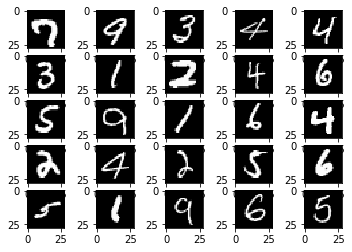

In [38]:
n=5
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [39]:
# Подготовка датасета
X_train = data_normalization(X_train)

# Splitting data on the training and the test samples
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, random_state=10)


In [40]:
# Определение слоев сети
class Dense:
    
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx
    
    
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz
    
    
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)
    
    
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -1. * np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return -1. * dz * self.y_true / self.y_hat
    

class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask
    
    
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d = Dense(784, 2, rlambda)
        self.m = ReLU()
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d.forward(x)
        net = self.m.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.m.backward(dz, lr)
        dz = self.d.backward(dz, lr)
        return dz

In [41]:
# Опеределение самой сети
# class MnistNet:
# ...

In [42]:
# Здесь процедура обучения
net = MnistNet(0)
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
for iter in range(500):
    L_acc = 0.
    sh = list(range(X_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = Y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= Y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= Y_test.shape[0]
    L_test.append(L_e_acc)
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))

0 iter loss. Train : 6.168708542021669 . Test : 6.184571470426589
1 iter loss. Train : 6.168349894754672 . Test : 6.184571481483927
2 iter loss. Train : 6.168349768583222 . Test : 6.184571482786118
3 iter loss. Train : 6.168349766835569 . Test : 6.1845714829387175
4 iter loss. Train : 6.168349766811535 . Test : 6.184571482956599
5 iter loss. Train : 6.168349766811272 . Test : 6.184571482958694
6 iter loss. Train : 6.168349766811244 . Test : 6.1845714829589395
7 iter loss. Train : 6.168349766811263 . Test : 6.184571482958968
8 iter loss. Train : 6.168349766811258 . Test : 6.1845714829589715
9 iter loss. Train : 6.168349766811223 . Test : 6.184571482958972
10 iter loss. Train : 6.168349766811251 . Test : 6.184571482958972
11 iter loss. Train : 6.168349766811229 . Test : 6.184571482958972
12 iter loss. Train : 6.168349766811244 . Test : 6.184571482958972
13 iter loss. Train : 6.168349766811225 . Test : 6.184571482958972
14 iter loss. Train : 6.168349766811261 . Test : 6.184571482958972
15

122 iter loss. Train : 6.168349766811235 . Test : 6.184571482958972
123 iter loss. Train : 6.168349766811248 . Test : 6.184571482958972
124 iter loss. Train : 6.168349766811261 . Test : 6.184571482958972
125 iter loss. Train : 6.168349766811257 . Test : 6.184571482958972
126 iter loss. Train : 6.168349766811264 . Test : 6.184571482958972
127 iter loss. Train : 6.168349766811238 . Test : 6.184571482958972
128 iter loss. Train : 6.168349766811268 . Test : 6.184571482958972
129 iter loss. Train : 6.168349766811264 . Test : 6.184571482958972
130 iter loss. Train : 6.168349766811251 . Test : 6.184571482958972
131 iter loss. Train : 6.168349766811206 . Test : 6.184571482958972
132 iter loss. Train : 6.1683497668112395 . Test : 6.184571482958972
133 iter loss. Train : 6.168349766811288 . Test : 6.184571482958972
134 iter loss. Train : 6.168349766811253 . Test : 6.184571482958972
135 iter loss. Train : 6.168349766811266 . Test : 6.184571482958972
136 iter loss. Train : 6.168349766811228 . Test

243 iter loss. Train : 6.168349766811256 . Test : 6.184571482958972
244 iter loss. Train : 6.168349766811255 . Test : 6.184571482958972
245 iter loss. Train : 6.16834976681123 . Test : 6.184571482958972
246 iter loss. Train : 6.16834976681122 . Test : 6.184571482958972
247 iter loss. Train : 6.168349766811266 . Test : 6.184571482958972
248 iter loss. Train : 6.168349766811253 . Test : 6.184571482958972
249 iter loss. Train : 6.16834976681124 . Test : 6.184571482958972
250 iter loss. Train : 6.168349766811236 . Test : 6.184571482958972
251 iter loss. Train : 6.168349766811248 . Test : 6.184571482958972
252 iter loss. Train : 6.168349766811246 . Test : 6.184571482958972
253 iter loss. Train : 6.168349766811253 . Test : 6.184571482958972
254 iter loss. Train : 6.168349766811253 . Test : 6.184571482958972
255 iter loss. Train : 6.168349766811247 . Test : 6.184571482958972
256 iter loss. Train : 6.168349766811224 . Test : 6.184571482958972
257 iter loss. Train : 6.1683497668112155 . Test : 

364 iter loss. Train : 6.168349766811196 . Test : 6.184571482958972
365 iter loss. Train : 6.168349766811214 . Test : 6.184571482958972
366 iter loss. Train : 6.168349766811244 . Test : 6.184571482958972
367 iter loss. Train : 6.168349766811277 . Test : 6.184571482958972
368 iter loss. Train : 6.168349766811237 . Test : 6.184571482958972
369 iter loss. Train : 6.168349766811247 . Test : 6.184571482958972
370 iter loss. Train : 6.1683497668112715 . Test : 6.184571482958972
371 iter loss. Train : 6.168349766811256 . Test : 6.184571482958972
372 iter loss. Train : 6.168349766811237 . Test : 6.184571482958972
373 iter loss. Train : 6.16834976681124 . Test : 6.184571482958972
374 iter loss. Train : 6.168349766811275 . Test : 6.184571482958972
375 iter loss. Train : 6.168349766811244 . Test : 6.184571482958972
376 iter loss. Train : 6.168349766811253 . Test : 6.184571482958972
377 iter loss. Train : 6.168349766811248 . Test : 6.184571482958972
378 iter loss. Train : 6.168349766811272 . Test 

485 iter loss. Train : 6.168349766811308 . Test : 6.184571482958972
486 iter loss. Train : 6.1683497668112794 . Test : 6.184571482958972
487 iter loss. Train : 6.168349766811232 . Test : 6.184571482958972
488 iter loss. Train : 6.1683497668112395 . Test : 6.184571482958972
489 iter loss. Train : 6.168349766811261 . Test : 6.184571482958972
490 iter loss. Train : 6.168349766811237 . Test : 6.184571482958972
491 iter loss. Train : 6.168349766811269 . Test : 6.184571482958972
492 iter loss. Train : 6.168349766811268 . Test : 6.184571482958972
493 iter loss. Train : 6.168349766811271 . Test : 6.184571482958972
494 iter loss. Train : 6.168349766811265 . Test : 6.184571482958972
495 iter loss. Train : 6.168349766811249 . Test : 6.184571482958972
496 iter loss. Train : 6.168349766811222 . Test : 6.184571482958972
497 iter loss. Train : 6.168349766811242 . Test : 6.184571482958972
498 iter loss. Train : 6.168349766811235 . Test : 6.184571482958972
499 iter loss. Train : 6.168349766811232 . Tes

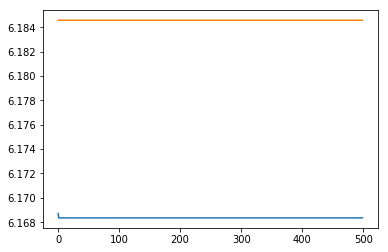

In [44]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label="train")
plt.plot(L_test, label="test")

In [ ]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_norm, net)